In [1]:
import pandas as pd
import numpy as np
import shap
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
data = yf.download("GOOGL", start="2015-01-01", end="2020-01-01")

/home/jupyter/.cache/pypoetry/virtualenvs/compare-multiple-backtests-2J6ybkfi-py3.10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [3]:
data["SMA50"] = data["Close"].rolling(window=50).mean()
data["EMA50"] = data["Close"].ewm(span=50, adjust=False).mean()

# RSI
delta = data["Close"].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data["RSI"] = 100 - (100 / (1 + rs))

# MACD
exp1 = data["Close"].ewm(span=12, adjust=False).mean()
exp2 = data["Close"].ewm(span=26, adjust=False).mean()
data["MACD"] = exp1 - exp2

# ATR
high_low = data["High"] - data["Low"]
high_close = (data["High"] - data["Close"].shift()).abs()
low_close = (data["Low"] - data["Close"].shift()).abs()
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
data["ATR"] = true_range.rolling(window=14).mean()

# Bollinger Bands
data["Middle_BB"] = data["Close"].rolling(window=20).mean()
data["Upper_BB"] = data["Middle_BB"] + 2 * data["Close"].rolling(window=20).std()
data["Lower_BB"] = data["Middle_BB"] - 2 * data["Close"].rolling(window=20).std()

# OBV
data["OBV"] = (np.sign(data["Close"].diff()) * data["Volume"]).fillna(0).cumsum()

# VWAP (assuming intraday data is available)
data["VWAP"] = (
    data["Volume"] * (data["High"] + data["Low"] + data["Close"]) / 3
).cumsum() / data["Volume"].cumsum()

In [4]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA50,EMA50,RSI,MACD,ATR,Middle_BB,Upper_BB,Lower_BB,OBV,VWAP
Date,,,,,,,,,,,,,,,,
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000,65.140280,65.217321,68.070234,0.767544,0.651570,66.734549,68.909130,64.559968,2.027282e+09,45.262523
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000,65.260510,65.331288,72.042115,0.779675,0.669821,66.858224,69.054337,64.662111,2.050944e+09,45.273942
2019-12-27,68.199997,68.352501,67.650002,67.732002,67.732002,23212000,65.372150,65.425434,60.039538,0.749064,0.664607,66.964499,69.110713,64.818285,2.027732e+09,45.285161
2019-12-30,67.840500,67.849998,66.891998,66.985497,66.985497,19994000,65.459060,65.486613,48.120979,0.656994,0.656321,67.053549,69.033653,65.073445,2.007738e+09,45.294531
2019-12-31,66.789497,67.032997,66.606499,66.969498,66.969498,19514000,65.554039,65.544765,47.999972,0.576096,0.636785,67.179874,68.735631,65.624117,1.988224e+09,45.303513


In [5]:
data["Future_Close"] = data["Close"].shift(-10)  # Shift by 10 days
data["Target"] = (data["Future_Close"] > data["Close"]).astype(int)
data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA50,EMA50,RSI,MACD,ATR,Middle_BB,Upper_BB,Lower_BB,OBV,VWAP,Future_Close,Target
Date,,,,,,,,,,,,,,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.477501,26480000,NaN,26.477501,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,26.553834,25.523001,0
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.973000,41182000,NaN,26.457717,NaN,-0.040245,NaN,NaN,NaN,NaN,-41182000.0,26.269496,25.497000,0
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.332001,54456000,NaN,26.413571,NaN,-0.122451,NaN,NaN,NaN,NaN,-95638000.0,25.951624,26.019501,1
2015-01-07,25.547501,25.574499,25.182501,25.257500,25.257500,46918000,NaN,26.368235,NaN,-0.191406,NaN,NaN,NaN,NaN,-142556000.0,25.781352,26.865000,1
2015-01-08,25.075500,25.375000,24.750999,25.345501,25.345501,73054000,NaN,26.328128,NaN,-0.236228,NaN,NaN,NaN,NaN,-69502000.0,25.592995,27.097500,1


In [6]:
X = data.drop(["Target", "Future_Close"], axis=1)
y = data["Target"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 586, number of negative: 420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582505 -> initscore=0.333065
[LightGBM] [Info] Start training from score 0.333065


/home/jupyter/.cache/pypoetry/virtualenvs/compare-multiple-backtests-2J6ybkfi-py3.10/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


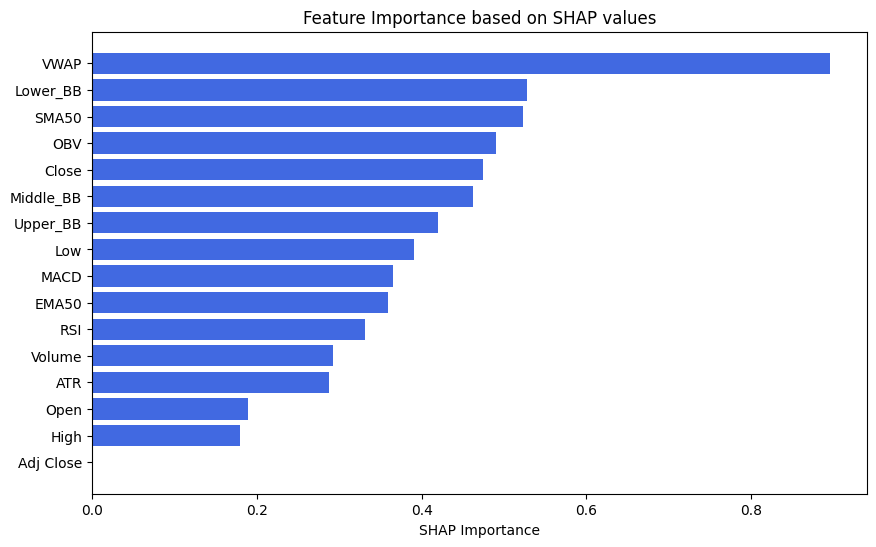

In [9]:
model = LGBMClassifier()
model.fit(X_train, y_train)

# Step 2: Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Assuming binary classification; adjust accordingly for multi-class
expected_value = (
    explainer.expected_value[1]
    if isinstance(explainer.expected_value, list)
    else explainer.expected_value
)
shap_values = shap_values[1] if isinstance(shap_values, list) else shap_values

# Step 3: Summarize SHAP values in a DataFrame
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ["feature", "shap_importance"]
importance_df["shap_importance"] = importance_df["shap_importance"].astype(float)
importance_df = importance_df.sort_values("shap_importance", ascending=False)

# Step 4: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"], importance_df["shap_importance"], color="royalblue")
plt.xlabel("SHAP Importance")
plt.title("Feature Importance based on SHAP values")
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

In [ ]:
fig = px.bar(
    importance_df,
    x="shap_importance",
    y="feature",
    orientation="h",
    title="Feature Importance based on SHAP values",
    color="shap_importance",
    labels={"shap_importance": "SHAP Importance", "feature": ""},
    color_continuous_scale="Blues",
)

fig.update_layout(yaxis={"categoryorder": "total ascending"})

fig.show()

In [10]:
top_5_features = importance_df.sort_values(by="shap_importance", ascending=False).head(
    5
)
selected_features = top_5_features["feature"].tolist()

In [11]:
selected_features

['VWAP', 'Lower_BB', 'SMA50', 'OBV', 'Close']

In [12]:
# Assuming `selected_features` are the features selected through some feature selection process
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initialize and train the model using the selected features
model = LGBMClassifier(random_state=42)
model.fit(X_train_selected, y_train)

[LightGBM] [Info] Number of positive: 586, number of negative: 420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582505 -> initscore=0.333065
[LightGBM] [Info] Start training from score 0.333065


LGBMClassifier(random_state=42)

In [13]:
# Predict on the test set
predictions = model.predict(X_test_selected)

# Calculate accuracy or any other performance metrics
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.873015873015873


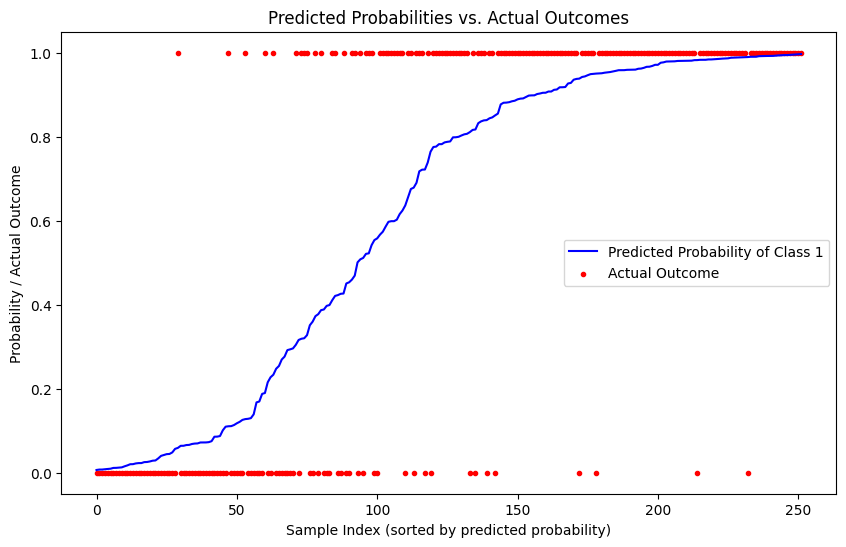

In [14]:
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (e.g., class "1")
probabilities = model.predict_proba(X_test_selected)[:, 1]

# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({"Actual": y_test, "Predicted": probabilities})

# Sort the DataFrame by predicted probabilities for better visualization
results_df = results_df.sort_values(by="Predicted")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
    results_df["Predicted"].values,
    label="Predicted Probability of Class 1",
    color="blue",
)
plt.scatter(
    range(len(results_df)),
    results_df["Actual"].values,
    marker=".",
    label="Actual Outcome",
    color="red",
)

# Enhancing the plot
plt.title("Predicted Probabilities vs. Actual Outcomes")
plt.xlabel("Sample Index (sorted by predicted probability)")
plt.ylabel("Probability / Actual Outcome")
plt.legend()
plt.show()

In [ ]:
model.fit(X[selected_features], y)

In [ ]:
predictions = model.predict(X[selected_features])
accuracy = accuracy_score(y, predictions)
print(f"Model Accuracy: {accuracy}")

In [15]:
import math
import warnings

warnings.filterwarnings("ignore")
from termcolor import colored as cl

In [18]:
def implement_strategy(df, investment):

    in_position = False
    equity = investment

    for i, row in df.iterrows():
        prob_negative, prob_positive = model.predict_proba(
            [row[selected_features].values]
        )[0]
        if prob_positive > 0.9 and in_position == False:
            no_of_shares = math.floor(equity / df.Close[i])
            equity -= no_of_shares * df.Close[i]
            in_position = True
            print(
                cl("BUY: ", color="green", attrs=["bold"]),
                f'{no_of_shares} Shares are bought at ${df.Close[i]} on {str(df["Date"][i])[:10]}',
            )
        elif prob_negative > (1 - 0.1) and in_position == True:
            equity += no_of_shares * df.Close[i]
            in_position = False
            print(
                cl("SELL: ", color="red", attrs=["bold"]),
                f'{no_of_shares} Shares are sold at ${df.Close[i]} on {str(df["Date"][i])[:10]}',
            )
    if in_position == True:
        equity += no_of_shares * df.Close[i]
        print(
            cl(
                f'\nClosing position at {df.Close[i]} on {str(df["Date"][i])[:10]}',
                attrs=["bold"],
            )
        )
        in_position = False

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)
    # return roi
    print(cl(f"EARNING: ${earning} ; ROI: {roi}%", attrs=["bold"]))

In [19]:
implement_strategy(X_test.reset_index(), 10000)

BUY:  166 Shares are bought at $60.134498596191406 on 2019-04-09
SELL:  166 Shares are sold at $43.5 on 2017-03-16
BUY:  121 Shares are bought at $59.492000579833984 on 2019-03-26
SELL:  121 Shares are sold at $37.42300033569336 on 2016-06-01
BUY:  119 Shares are bought at $38.0984992980957 on 2016-07-27
SELL:  119 Shares are sold at $39.0 on 2016-04-21
BUY:  118 Shares are bought at $39.43600082397461 on 2016-09-13
SELL:  118 Shares are sold at $39.109500885009766 on 2016-11-03
BUY:  135 Shares are bought at $34.15850067138672 on 2015-10-13
SELL:  135 Shares are sold at $60.576499938964844 on 2018-10-03
BUY:  303 Shares are bought at $27.00200080871582 on 2015-06-30
SELL:  303 Shares are sold at $38.067501068115234 on 2016-01-29
BUY:  436 Shares are bought at $26.491500854492188 on 2015-02-05
SELL:  436 Shares are sold at $38.96049880981445 on 2015-12-04
BUY:  483 Shares are bought at $35.17649841308594 on 2016-06-30
SELL:  483 Shares are sold at $27.877500534057617 on 2015-03-27
BUY:

SELL:  821 Shares are sold at $61.400001525878906 on 2019-07-30
BUY:  1391 Shares are bought at $36.24300003051758 on 2016-02-26
SELL:  1391 Shares are sold at $59.20349884033203 on 2018-06-20
BUY:  1604 Shares are bought at $51.32749938964844 on 2018-03-23
SELL:  1604 Shares are sold at $43.229000091552734 on 2017-03-13
BUY:  1622 Shares are bought at $42.756500244140625 on 2017-04-17
SELL:  1622 Shares are sold at $59.37799835205078 on 2018-01-26
BUY:  1549 Shares are bought at $62.150001525878906 on 2019-10-16
SELL:  1549 Shares are sold at $58.29650115966797 on 2018-03-12
BUY:  1798 Shares are bought at $50.253501892089844 on 2017-10-20
SELL:  1798 Shares are sold at $34.70199966430664 on 2015-08-19
BUY:  1518 Shares are bought at $41.08100128173828 on 2017-02-06
SELL:  1518 Shares are sold at $27.840499877929688 on 2015-05-21
BUY:  1321 Shares are bought at $32.00749969482422 on 2015-09-25
SELL:  1321 Shares are sold at $38.29199981689453 on 2015-12-24
BUY:  1138 Shares are bought